In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timeit
import pandas as pd
from typing import NamedTuple, List, Tuple
from IPython.display import display
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment

import sys
# Add measurement mcts python package to path
sys.path.append('../src/measurement_mcts')
from measurement_mcts.environment.measurement_control_env import MeasurementControlEnvironment
from measurement_mcts.environment.object_manager import ObjectTuple, get_empty_df

/home/austin/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = get_empty_df()
display(df.head())
df.info()

,object_type,shape,mean,ooi_id,points,covariances,radius,observed,in_collision


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   object_type   0 non-null      object 
 1   shape         0 non-null      object 
 2   mean          0 non-null      object 
 3   ooi_id        0 non-null      int64  
 4   points        0 non-null      object 
 5   covariances   0 non-null      object 
 6   radius        0 non-null      float64
 7   observed      0 non-null      object 
 8   in_collision  0 non-null      bool   
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 124.0+ bytes


Shape of rects: (4, 4, 2)


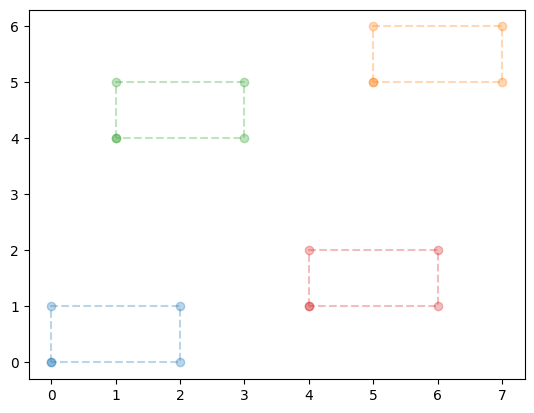

In [2]:
# Create a 4 point rectangle (4,2 points)
rect = np.array([[0, 0], [0, 1], [2, 1], [2, 0]])
rect2 = rect + np.array([5, 5])
rect3 = rect + np.array([1, 4])
rect4 = rect + np.array([4, 1])

rects = np.stack((rect, rect2, rect3, rect4))
print(f'Shape of rects: {rects.shape}')

def plot_rectangles(rects: List[np.ndarray], marker='o--', alpha=0.3):
    for rect in rects:
        rect = np.append(rect, [rect[0]], axis=0)
        plt.plot(rect[:, 0], rect[:, 1], marker, alpha=alpha)

plot_rectangles(rects)

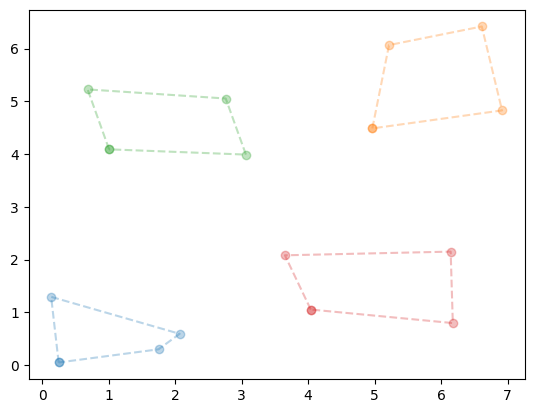

In [3]:
# Add noise to the rectangles
noise = np.random.normal(0, 0.2, rects.shape)
noisy_rects = rects + noise

plot_rectangles(noisy_rects, marker='o--', alpha=0.3)

In [4]:
env = MeasurementControlEnvironment(init_reset=False)
df = pd.DataFrame()

obs_dict, new_df, new_rects = env.corner_data_association(rects, df)
print(f'New rects: {new_rects}')
new_df.head()

Toy Measurement Control Initialized
Adding OOI with id 0
Adding OOI with id 1
Adding OOI with id 2
Adding OOI with id 3
New rects: []


,object_type,shape,mean,ooi_id,points,covariances,radius,observed,in_collision
0,ooi,4polygon,"[1.0, 0.5]",0,"[[0, 0], [0, 1], [2, 1], [2, 0]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
1,ooi,4polygon,"[6.0, 5.5]",1,"[[5, 5], [5, 6], [7, 6], [7, 5]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
2,ooi,4polygon,"[2.0, 4.5]",2,"[[1, 4], [1, 5], [3, 5], [3, 4]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
3,ooi,4polygon,"[5.0, 1.5]",3,"[[4, 1], [4, 2], [6, 2], [6, 1]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False


In [5]:
# Apply the observations to the environment and maintain new object state dataframe
new_df, trace_delta_sum = env.apply_observation(obs_dict, new_df, np.zeros(6), new_rects)
new_df.head()

,object_type,shape,mean,ooi_id,points,covariances,radius,observed,in_collision
0,ooi,4polygon,"[1.0, 0.5]",0,"[[0, 0], [0, 1], [2, 1], [2, 0]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
1,ooi,4polygon,"[6.0, 5.5]",1,"[[5, 5], [5, 6], [7, 6], [7, 5]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
2,ooi,4polygon,"[2.0, 4.5]",2,"[[1, 4], [1, 5], [3, 5], [3, 4]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
3,ooi,4polygon,"[5.0, 1.5]",3,"[[4, 1], [4, 2], [6, 2], [6, 1]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False


In [6]:
obs_dict, new_new_df, new_new_rects = env.corner_data_association(noisy_rects, new_df)
print(f'Observation dictionary: {obs_dict}')
print(f'New new rects: {new_new_rects}')
new_new_df.head()

Observation dictionary: {0: array([0, 1, 2, 3]), 1: array([0, 1, 2, 3]), 2: array([0, 1, 2, 3]), 3: array([0, 1, 2, 3])}
New new rects: [[[0.24858434 0.05170612]
  [0.13563391 1.29524582]
  [2.06862528 0.59485045]
  [1.75072219 0.30093115]]

 [[4.96664666 4.48680198]
  [5.21772939 6.0658609 ]
  [6.61310352 6.41816074]
  [6.91771325 4.82795091]]

 [[1.00726736 4.09039572]
  [0.68400148 5.22577493]
  [2.76160979 5.05325414]
  [3.06525348 3.99064345]]

 [[4.04067134 1.05488244]
  [3.6515131  2.08241423]
  [6.14481055 2.15222342]
  [6.17711014 0.79830702]]]


,object_type,shape,mean,ooi_id,points,covariances,radius,observed,in_collision
0,ooi,4polygon,"[1.0, 0.5]",0,"[[0, 0], [0, 1], [2, 1], [2, 0]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
1,ooi,4polygon,"[6.0, 5.5]",1,"[[5, 5], [5, 6], [7, 6], [7, 5]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
2,ooi,4polygon,"[2.0, 4.5]",2,"[[1, 4], [1, 5], [3, 5], [3, 4]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False
3,ooi,4polygon,"[5.0, 1.5]",3,"[[4, 1], [4, 2], [6, 2], [6, 1]]","[[[8.0, 0.0], [0.0, 8.0]], [[8.0, 0.0], [0.0, ...",None,"[False, False, False, False]",False


In [7]:
# Apply the observations to the environment and maintain new object state dataframe
new_new_df, trace_delta_sum = env.apply_observation(obs_dict, new_new_df, np.zeros(6), new_new_rects)
new_new_df.head()

Current means: [[0 0]
 [0 1]
 [2 1]
 [2 0]]
Current covariances: [array([[8., 0.],
       [0., 8.]]), array([[8., 0.],
       [0., 8.]]), array([[8., 0.],
       [0., 8.]]), array([[8., 0.],
       [0., 8.]])]
Indices of this observation: 0, 0
Real Observation: [[[0.24858434 0.05170612]
  [0.13563391 1.29524582]
  [2.06862528 0.59485045]
  [1.75072219 0.30093115]]

 [[4.96664666 4.48680198]
  [5.21772939 6.0658609 ]
  [6.61310352 6.41816074]
  [6.91771325 4.82795091]]

 [[1.00726736 4.09039572]
  [0.68400148 5.22577493]
  [2.76160979 5.05325414]
  [3.06525348 3.99064345]]

 [[4.04067134 1.05488244]
  [3.6515131  2.08241423]
  [6.14481055 2.15222342]
  [6.17711014 0.79830702]]]
This Observation: [0.24858434 0.05170612]
This observation shape (2,)
Current mean shape (2,)
Indices of this observation: 0, 1
Real Observation: [[[0.24858434 0.05170612]
  [0.13563391 1.29524582]
  [2.06862528 0.59485045]
  [1.75072219 0.30093115]]

 [[4.96664666 4.48680198]
  [5.21772939 6.0658609 ]
  [6.61310

,object_type,shape,mean,ooi_id,points,covariances,radius,observed,in_collision
0,ooi,4polygon,"[1.0, 0.5]",0,"[[0, 0], [0, 1], [2, 0], [1, 0]]","[[[2.9796642409314833, 0.4675853011348388], [0...",None,"[False, False, False, False]",False
1,ooi,4polygon,"[6.0, 5.5]",1,"[[5, 4], [5, 6], [6, 6], [6, 4]]","[[[3.177087697146355, 0.5171173631343582], [0....",None,"[False, False, False, False]",False
2,ooi,4polygon,"[2.0, 4.5]",2,"[[1, 4], [0, 5], [2, 5], [3, 3]]","[[[3.15428332778661, -0.019050101952343145], [...",None,"[False, False, False, False]",False
3,ooi,4polygon,"[5.0, 1.5]",3,"[[4, 1], [3, 2], [6, 2], [6, 0]]","[[[2.937453946882827, 0.53422911632428], [0.53...",None,"[False, False, False, False]",False


In [51]:
def corner_data_association(obs_rects: np.ndarray, rects: np.ndarray) -> dict:
    # Create output observation dictionary
    obs_dict = {}
    
    # First calculate centroids of the rectangles
    obs_centroids = np.mean(obs_rects, axis=1)
    centroids = np.mean(rects, axis=1)
    
    # Calculate distance between all pairs of centroids
    distances = cdist(obs_centroids, centroids)
    
    # Solve the assignment problem to find the best match using scipy
    row_ind, col_ind = linear_sum_assignment(distances)
    # print(f'Row indices: {row_ind}')
    # print(f'Column indices: {col_ind}')
    
    # # Organize the rectangles based on the assignment 
    assigned_rects = rects[col_ind]
    # print(f'Assigned rectangles: {assigned_rects}')
    # print(f'Observed rectangles: {obs_rects}')
    
    # Now with objects associated, perform point to point data association
    for i, (obs_rect, maint_rect) in enumerate(zip(obs_rects, assigned_rects)):
        distances = cdist(obs_rect, maint_rect)
        row_idx, col_idx = linear_sum_assignment(distances)
        # print(f'Row indices: {row_idx}')
        # print(f'Column indices: {col_idx}')
        obs_dict[i] = col_idx

    return obs_dict

# Re-arange the noisy rectangles to test data association
noisy_re_arranged_rects = np.stack((noisy_rects[1], noisy_rects[2], noisy_rects[3]))

# Re-arange the points to test data association
noisy_re_arranged_rects = np.stack((noisy_re_arranged_rects[:,1], noisy_re_arranged_rects[:,0], noisy_re_arranged_rects[:,2], noisy_re_arranged_rects[:,3]), axis=1)

obs_dict = corner_data_association(noisy_re_arranged_rects, rects)
print(f'Observation dictionary: {obs_dict}')
    

Row indices: [0 1 2 3]
Column indices: [1 0 2 3]
index i: 0
Row indices: [0 1 2 3]
Column indices: [1 0 2 3]
index i: 1
Row indices: [0 1 2 3]
Column indices: [1 0 2 3]
index i: 2
Observation dictionary: {0: array([1, 0, 2, 3]), 1: array([1, 0, 2, 3]), 2: array([1, 0, 2, 3])}
